Missing value, outlier treatment (EDA analysis aswell).

# 🧾 Problem Statement:
### Optimizing Inventory Management for Tops Liquor Stores in South Africa

Tops, a leading liquor retail chain in South Africa, operates across multiple store locations and carries a wide variety of alcoholic beverages. The brand seeks to optimize its inventory management system to enhance operational efficiency, reduce carrying costs, and ensure product availability across all its stores.

Currently, inventory data is scattered across various sources including purchase records, sales data, opening stock levels, and individual store information. However, the absence of a centralized, predictive system often results in **stockouts**, **overstocking**, and inefficient **reorder processes**—negatively impacting sales and increasing operational costs.

The goal of this project is to develop a data-driven inventory management solution for Tops that:

- Accurately forecasts product demand at each store based on historical sales and seasonality.
- Optimizes stock levels to avoid both overstocking and stockouts.
- Provides intelligent reorder recommendations to streamline procurement.
- Supports better inventory visibility across the Tops network of stores.

Using available datasets on inventory, purchases, sales, and store locations, this system will help Tops make smarter inventory decisions and better align stock levels with customer demand.

## Data prep and load

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer
import seaborn as sns
from datetime import datetime, timedelta
from scipy.stats import pearsonr  
import os
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.2f}'.format)

# Load the datasets
inventory = pd.read_csv('../../Data/Processed/Inventory.csv')
opening_stock = pd.read_csv('../../Data/Processed/OpeningStock.csv')
purchases = pd.read_csv('../../Data/Processed/Purchases.csv')
sales = pd.read_csv('../../Data/Processed/Sales.csv')
stores = pd.read_csv('../../Data/Processed/Stores.csv')


# Convert date columns to datetime
opening_stock['startDate'] = pd.to_datetime(opening_stock['startDate'])
purchases['PODate'] = pd.to_datetime(purchases['PODate'])
purchases['ReceivingDate'] = pd.to_datetime(purchases['ReceivingDate'])
sales['SalesDate'] = pd.to_datetime(sales['SalesDate'])

 



## EDA analysis

### Missing value analysis

In [66]:
print('Info of "inventory" dataframe')
inventory.info()
print()

print('Info of "opening_stock" dataframe')
opening_stock.info()
print()

print('Info of "purchases" dataframe')
purchases.info()
print()

print('Info of "sales" dataframe')
sales.info()
print()

print('Info of "stores" dataframe')
stores.info()
print()


Info of "inventory" dataframe
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11613 entries, 0 to 11612
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ItemID       11613 non-null  int64 
 1   Description  11613 non-null  object
dtypes: int64(1), object(1)
memory usage: 181.6+ KB

Info of "opening_stock" dataframe
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5944 entries, 0 to 5943
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   StoreID    5944 non-null   int64         
 1   onHand     5944 non-null   int64         
 2   startDate  5944 non-null   datetime64[ns]
 3   ItemId     5944 non-null   int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 185.9 KB

Info of "purchases" dataframe
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70426 entries, 0 to 70425
Data columns (total 5 columns):
 #   Column         Non-N

### Check for duplicates
We only check for duplicate products as that is the only field that should not contain any duplicates. It is possible that the same purchase or sale could take place on the same day so we do not check for any duplicates.

In [67]:
duplicates = inventory[inventory.duplicated()]
print(duplicates)

Empty DataFrame
Columns: [ItemID, Description]
Index: []


### Check for outliers

In [68]:
opening_stock.describe().T

,count,mean,min,25%,50%,75%,max,std
StoreID,5944.00,1.45,1.00,1.00,1.00,2.00,2.00,0.50
onHand,5944.00,17.30,0.00,6.00,11.00,19.00,346.00,24.27
startDate,5944,2015-12-31 00:00:00,2015-12-31 00:00:00,2015-12-31 00:00:00,2015-12-31 00:00:00,2015-12-31 00:00:00,2015-12-31 00:00:00,NaN
ItemId,5944.00,13026.67,58.00,3607.75,6938.00,20137.00,47090.00,12719.70


Text(0.5, 1.0, 'Box Plot: Raw Features')

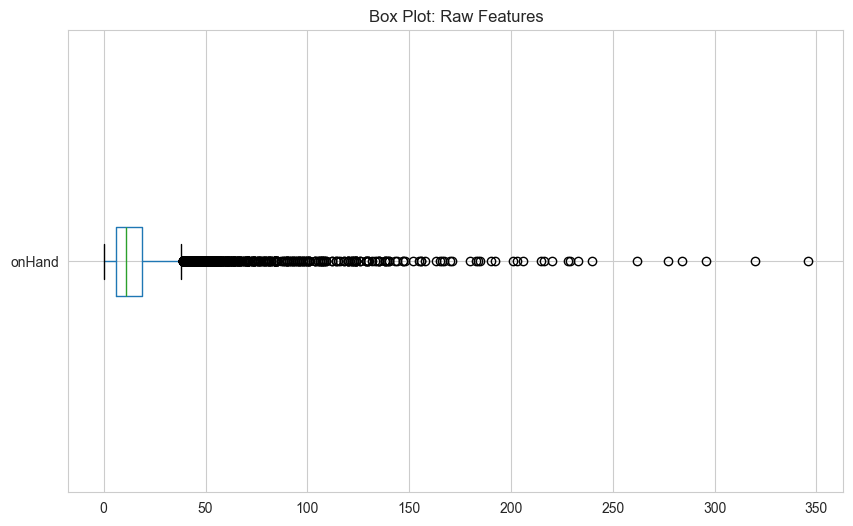

In [69]:
fig, ax = plt.subplots(figsize=(10, 6))
boxplot = opening_stock[['onHand']].boxplot(vert=False, ax=ax)
ax.set_title('Box Plot: Raw Features')

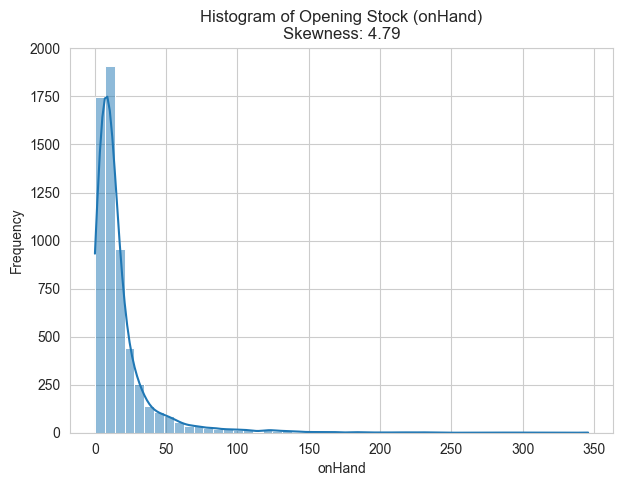

In [70]:
# Set up the plotting style
sns.set_style("whitegrid")

# Create a single figure
plt.figure(figsize=(7, 5))

# Plot histogram for raw onHand
sns.histplot(data=opening_stock, x="onHand", bins=50, kde=True)
plt.title(f"Histogram of Opening Stock (onHand)\nSkewness: {opening_stock['onHand'].skew():.2f}")
plt.xlabel("onHand")
plt.ylabel("Frequency")

# Show plot
plt.show()

In [71]:
purchases.describe().T

,count,mean,min,25%,50%,75%,max,std
StoreID,70426.00,1.40,1.00,1.00,1.00,2.00,2.00,0.49
PODate,70426,2016-06-30 16:42:12.564677888,2015-12-20 00:00:00,2016-04-03 00:00:00,2016-07-03 00:00:00,2016-10-02 00:00:00,2016-12-23 00:00:00,NaN
ReceivingDate,70426,2016-07-08 16:12:21.408002816,2016-01-01 00:00:00,2016-04-11 00:00:00,2016-07-11 00:00:00,2016-10-10 00:00:00,2016-12-31 00:00:00,NaN
Quantity,70426.00,14.34,1.00,6.00,11.00,12.00,407.00,21.39
ItemId,70426.00,12386.16,58.00,3612.00,6429.00,18743.00,90631.00,12624.44


Text(0.5, 1.0, 'Box Plot: Raw Features')

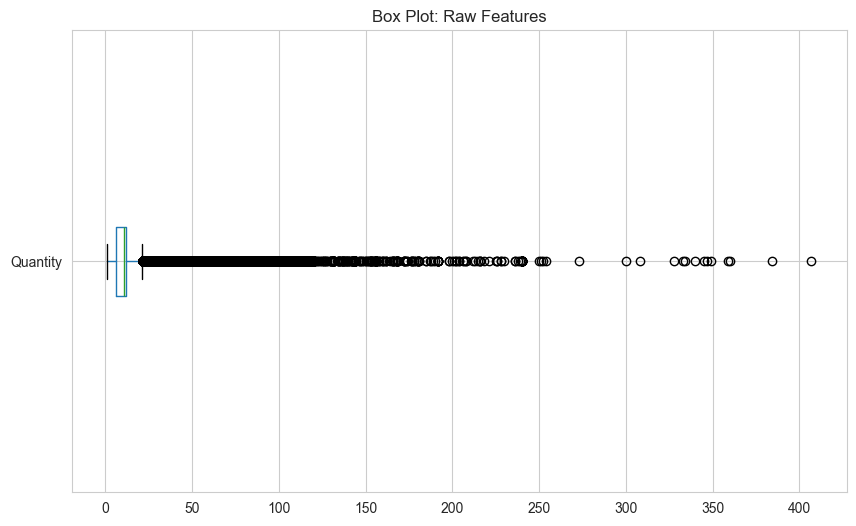

In [72]:
fig, ax = plt.subplots(figsize=(10, 6))
boxplot = purchases[['Quantity']].boxplot(vert=False, ax=ax)
ax.set_title('Box Plot: Raw Features')

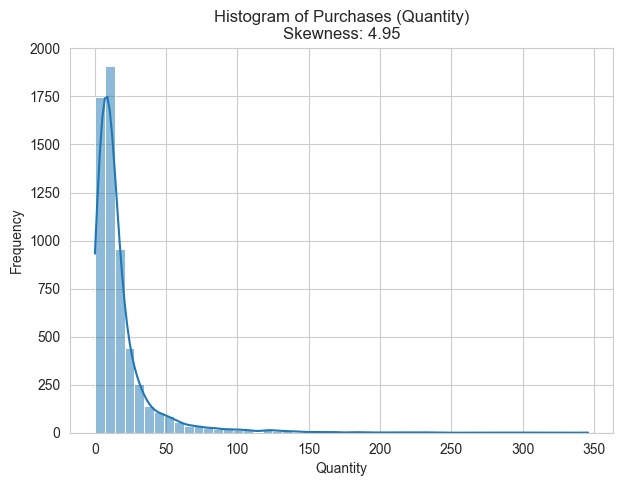

In [73]:
# Set up the plotting style
sns.set_style("whitegrid")

# Create a single figure
plt.figure(figsize=(7, 5))

# Plot histogram for raw onHand
sns.histplot(data=opening_stock, x="onHand", bins=50, kde=True)
plt.title(f"Histogram of Purchases (Quantity)\nSkewness: {purchases['Quantity'].skew():.2f}")
plt.xlabel("Quantity")
plt.ylabel("Frequency")

# Show plot
plt.show()

In [74]:
sales.describe().T

,count,mean,min,25%,50%,75%,max,std
StoreID,47138.00,1.26,1.00,1.00,1.00,2.00,2.00,0.44
SalesQuantity,47138.00,2.32,1.00,1.00,1.00,2.00,180.00,3.30
SalesDate,47138,2016-01-27 12:06:04.750307840,2016-01-01 00:00:00,2016-01-14 00:00:00,2016-01-26 00:00:00,2016-02-10 00:00:00,2016-02-29 00:00:00,NaN
ItemId,47138.00,12481.78,58.00,3696.00,6542.00,18592.00,47090.00,12552.47


Text(0.5, 1.0, 'Box Plot: Raw Features')

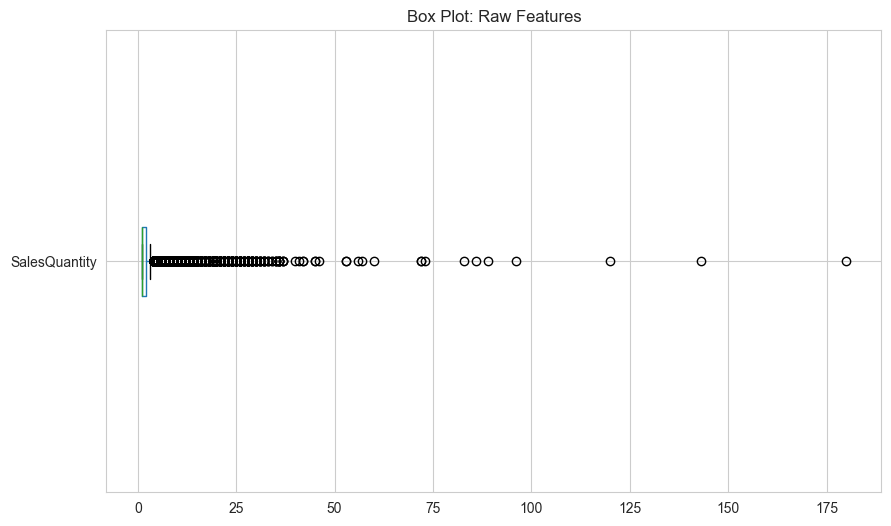

In [75]:
fig, ax = plt.subplots(figsize=(10, 6))
boxplot = sales[['SalesQuantity']].boxplot(vert=False, ax=ax)
ax.set_title('Box Plot: Raw Features')

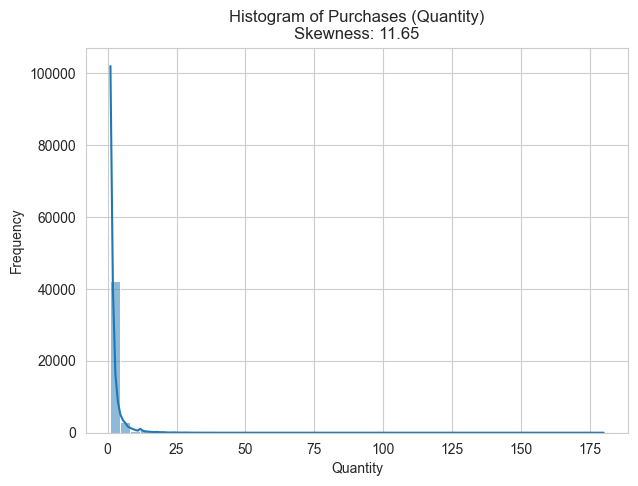

In [76]:
# Set up the plotting style
sns.set_style("whitegrid")

# Set up the plotting style
sns.set_style("whitegrid")

# Create a single figure
plt.figure(figsize=(7, 5))

# Plot histogram for raw onHand
sns.histplot(data=sales, x="SalesQuantity", bins=50, kde=True)
plt.title(f"Histogram of Purchases (Quantity)\nSkewness: {sales['SalesQuantity'].skew():.2f}")
plt.xlabel("Quantity")
plt.ylabel("Frequency")

# Show plot
plt.show()

## Sales analysis

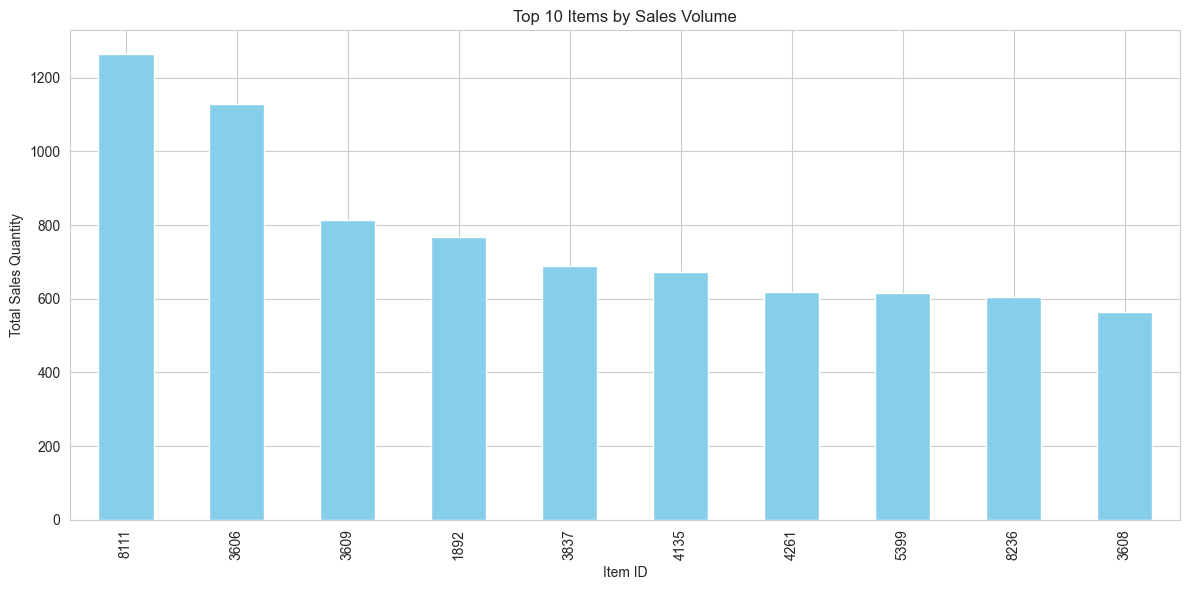

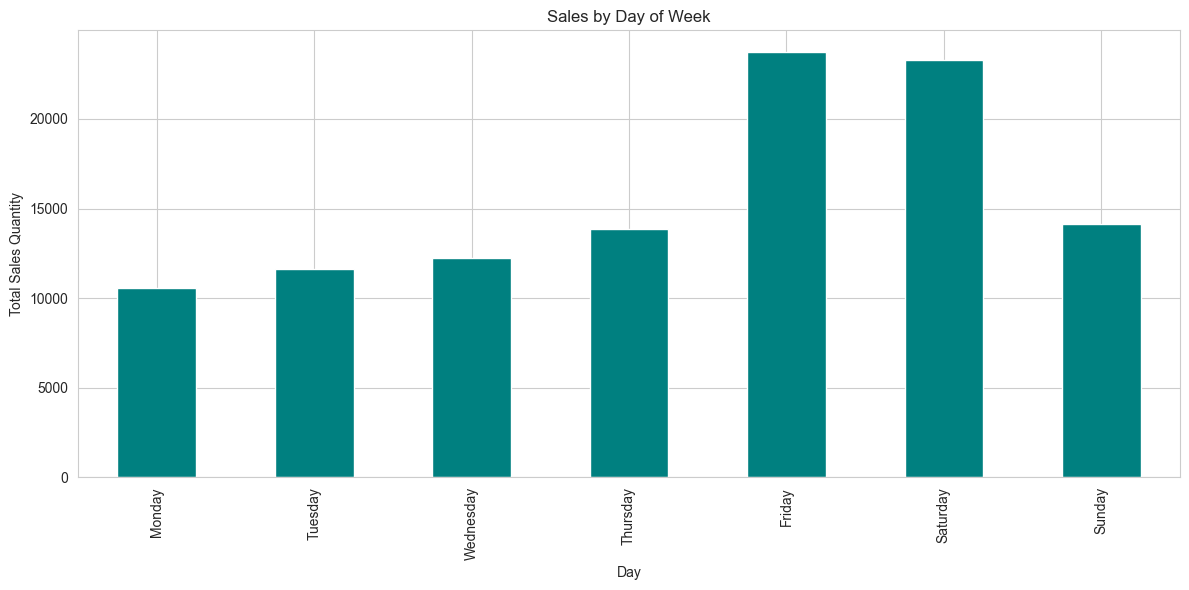

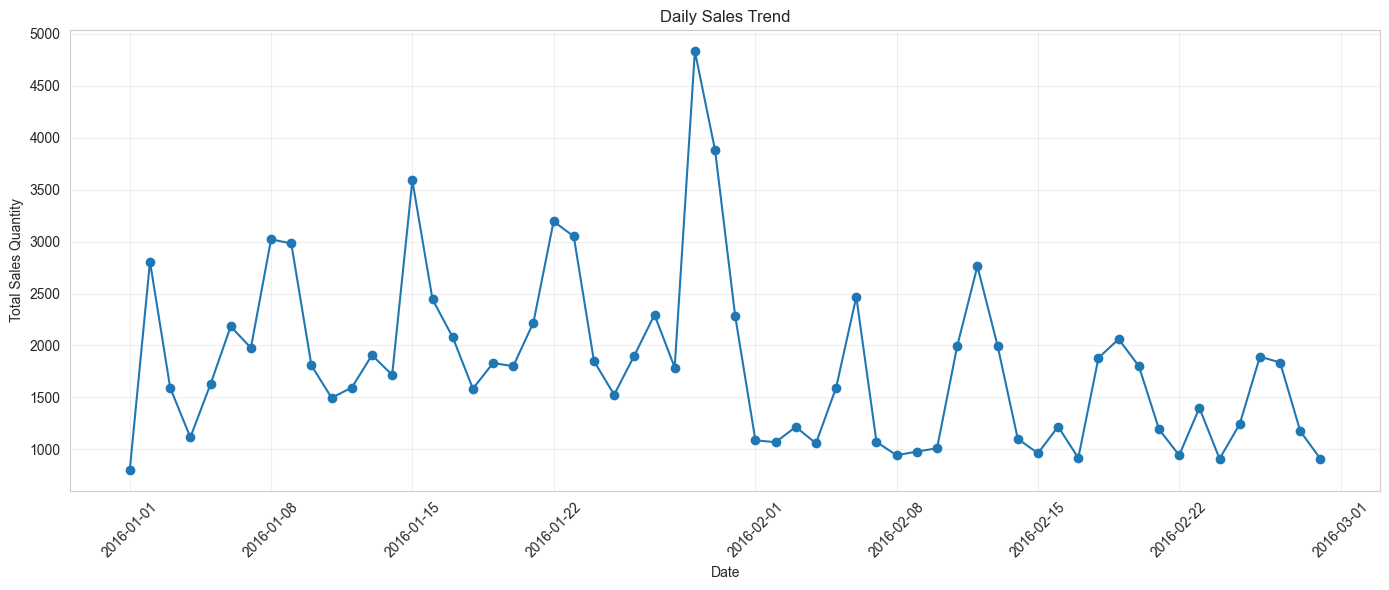

In [78]:
# 1. Top 10 Items by Sales Volume
top_items = sales.groupby('ItemId')['SalesQuantity'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
top_items.plot(kind='bar', color='skyblue')
plt.title('Top 10 Items by Sales Volume')
plt.xlabel('Item ID')
plt.ylabel('Total Sales Quantity')
plt.tight_layout()


# 2. Sales by Day of Week
sales['DayOfWeek'] = sales['SalesDate'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_sales = sales.groupby('DayOfWeek')['SalesQuantity'].sum()
day_sales = day_sales.reindex(day_order)

plt.figure(figsize=(12, 6))
day_sales.plot(kind='bar', color='teal')
plt.title('Sales by Day of Week')
plt.xlabel('Day')
plt.ylabel('Total Sales Quantity')
plt.tight_layout()


# 3. Sales Trend Over Time
daily_sales = sales.groupby('SalesDate')['SalesQuantity'].sum().reset_index()
plt.figure(figsize=(14, 6))
plt.plot(daily_sales['SalesDate'], daily_sales['SalesQuantity'], marker='o', linestyle='-')
plt.title('Daily Sales Trend')
plt.xlabel('Date')
plt.ylabel('Total Sales Quantity')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()



## Purchases analysis

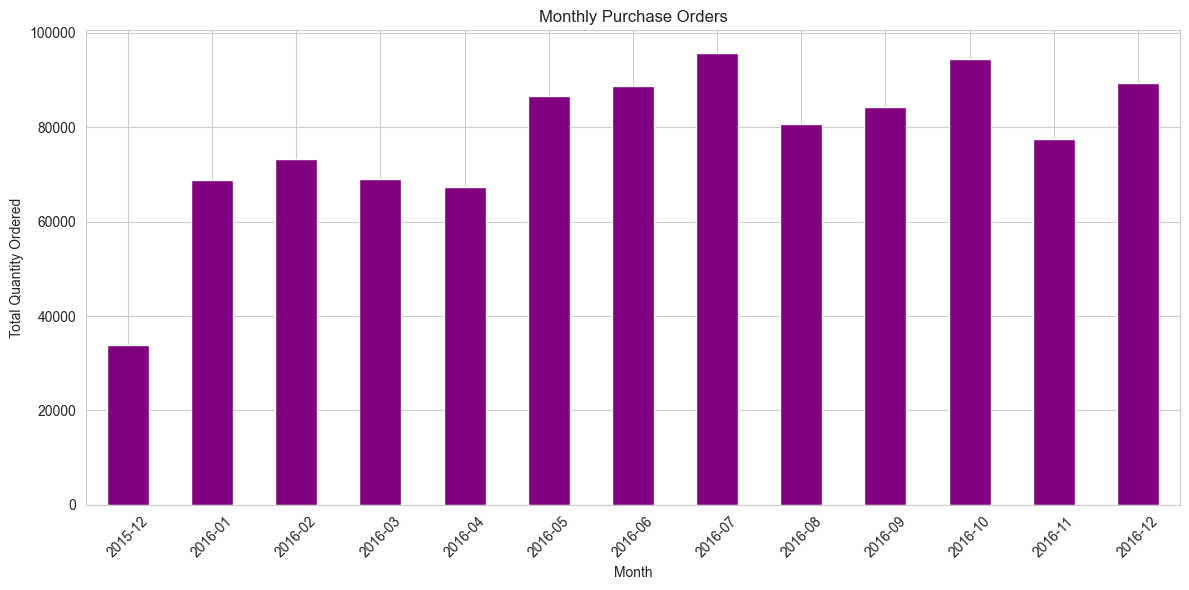

In [79]:
# 4. Purchase Order Patterns
monthly_purchases = purchases.groupby(purchases['PODate'].dt.to_period('M'))['Quantity'].sum()
plt.figure(figsize=(12, 6))
monthly_purchases.plot(kind='bar', color='purple')
plt.title('Monthly Purchase Orders')
plt.xlabel('Month')
plt.ylabel('Total Quantity Ordered')
plt.xticks(rotation=45)
plt.tight_layout()



## Lead time analysis



Lead Time Analysis

Lead Time Summary Statistics:
count   70426.00
mean        7.98
std         2.23
min         3.00
25%         6.00
50%         8.00
75%        10.00
max        14.00
Name: lead_time, dtype: float64


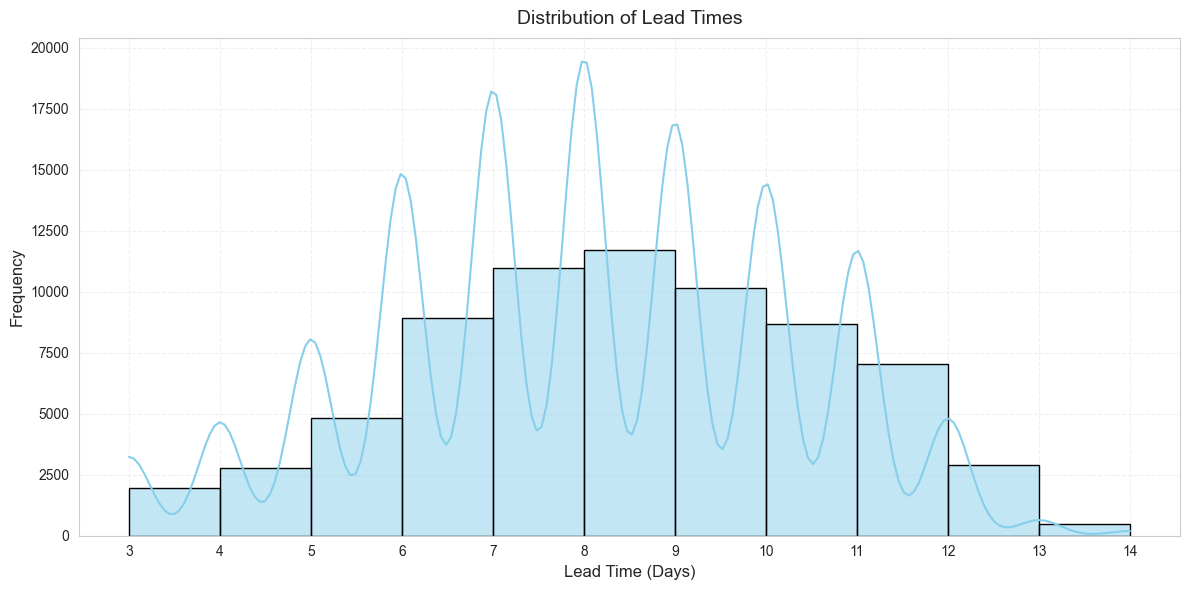

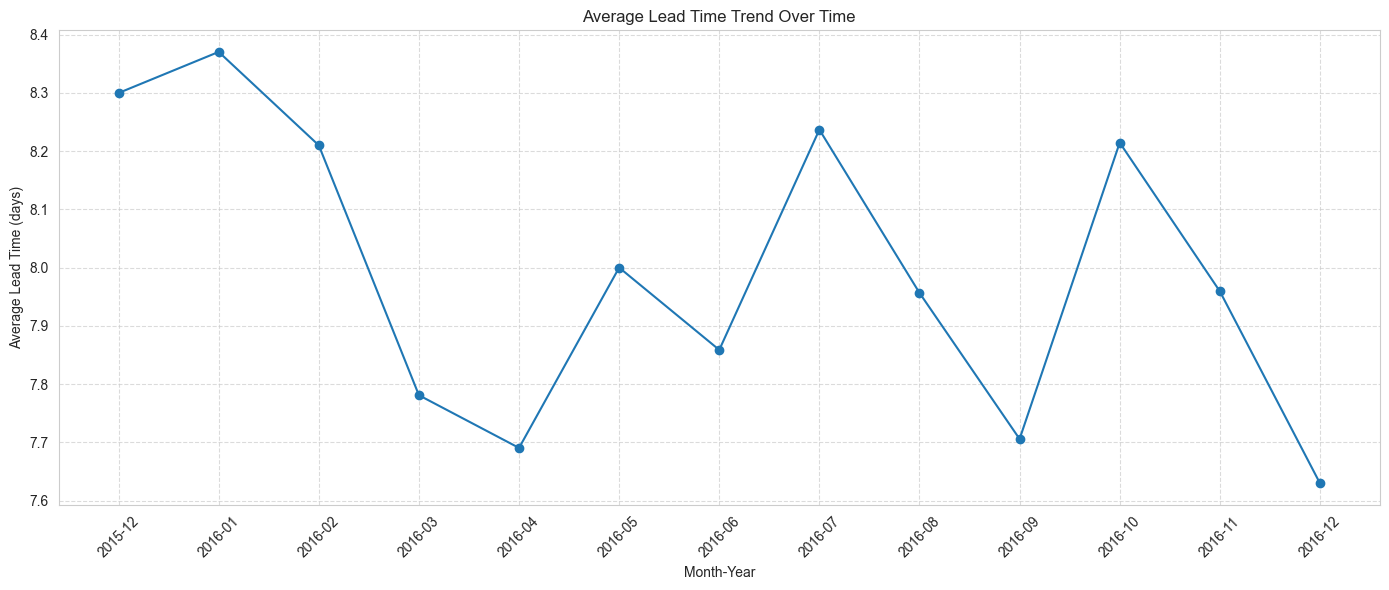

In [80]:

purchases['lead_time'] = (purchases['ReceivingDate'] - purchases['PODate']).dt.days

# Print the lead time
print("\n\n" + "="*50)
print("Lead Time Analysis")
print("="*50)

print("\nLead Time Summary Statistics:")
print(purchases['lead_time'].describe())

# 5. Lead Time Analysis (time between PO and Receiving)
purchases['LeadTime'] = (purchases['ReceivingDate'] - purchases['PODate']).dt.days
# Create the plot
plt.figure(figsize=(12, 6))

# Plot histogram with integer bins (one bin per day from 3 to 14) 
bins = range(3, 15)  ## (From the Lead time stats we could see that Lead time had a min of 3 and max of 14)
sns.histplot(data=purchases, x='LeadTime', bins=bins, kde=True, 
             stat='count', color='skyblue', edgecolor='black')

# Customize the plot
plt.title('Distribution of Lead Times', fontsize=14, pad=10)
plt.xlabel('Lead Time (Days)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')

# Ensure x-axis shows integer ticks
plt.xticks(range(3, 15))

# Adjust layout and save
plt.tight_layout()
plt.show()

# 6.Analyze changes in lead time over time
purchases['month_year'] = purchases['PODate'].dt.to_period('M')
lead_time_trend = purchases.groupby('month_year')['lead_time'].mean().reset_index()
lead_time_trend['month_year'] = lead_time_trend['month_year'].astype(str)

plt.figure(figsize=(14, 6))
plt.plot(lead_time_trend['month_year'], lead_time_trend['lead_time'], marker='o')
plt.title('Average Lead Time Trend Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Average Lead Time (days)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()